<a href="https://colab.research.google.com/github/k3larra/gen1/blob/pc/shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On concepts explanations and stuff like that.
Raw version 


# Setup

In [ ]:
import os
import csv
import sys
import urllib
import json
import random
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.optim import lr_scheduler
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from os import listdir
from os.path import isfile, join
from io import StringIO 
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import matplotlib.pyplot as plt
from zipfile import ZipFile
from random import randint
print(torch.__version__)

1.12.0+cu113


In [ ]:
# Set random seed for reproducibility.
np.random.seed(131254)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Training set

In [ ]:
#The kaggle token
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"larsholmberg","key":"4b2c0a02173702dff658e9ba068fb558"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download smeschke/four-shapes
with ZipFile('/content/four-shapes.zip', 'r') as archive:
  archive.extractall('/content')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 21.6M/21.6M [00:00<00:00, 39.6MB/s]
100% 21.6M/21.6M [00:00<00:00, 32.5MB/s]


###Test set


In [ ]:
! git clone https://github.com/k3larra/XAI-F
with ZipFile('/content/XAI-F/testset.zip', 'r') as archive:
  archive.extractall('/content/testshapes')


Cloning into 'XAI-F'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 89 (delta 36), reused 68 (delta 26), pack-reused 3
Unpacking objects: 100% (89/89), done.


## Dataloader


In [ ]:
# create the annotation file for the tests!
shape_path = "/content/testshapes"
with open(shape_path + '/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir(shape_path):
        # print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join(shape_path, dirs)):
            if(join(shape_path, dirs, f).endswith(".csv")):
                continue
            elif isfile(join(shape_path, dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [ ]:
# create the annotation file for the training!
shape_path = "/content/shapes"
shapes_to_ignore = ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
labels_to_ignore = []
with open('/content/shapes/shapes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_location', 'label']) # Write header
    for dirs in listdir("/content/shapes"):
        if dirs in labels_to_ignore: #Ignore label!
          continue
#         print(dirs)
        if(dirs.endswith(".csv")):
            continue
        for f in listdir(join("/content/shapes", dirs)):
            if f in shapes_to_ignore: #ignore the images! 
              continue
            elif(join("/content/shapes", dirs, f).endswith(".csv")):
                continue
            elif isfile(join("/content/shapes", dirs, f)):
                writer.writerow([join(dirs, f), dirs])

In [ ]:
num_classes = 4
possible_labels = {"circle": 0, "square": 1, "star": 2, "triangle": 3}
key_list = list(possible_labels.keys())
val_list = list(possible_labels.values())
def label_to_idx(label):
  return possible_labels[label]
def idx_to_label(idx):
  position = val_list.index(idx)
  return key_list[position]

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resizer = transforms.Resize(size=(299, 299)) 
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # Converts to tensor
        image = image.float()
        image /= 255.
        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label_to_idx(label))
        # ADDDITIONS TO TRANSFORM THE INPUT
        r = random.random() # 33% (equal probability) to zoom-in, zoom-out, dont transform
        if r < 0.33: # We zoom-in the shape!
          top = random.randrange(0, 40) 
          left = top
          dif = 40 - top
          w = 120 + dif
          h = w
          image = transformsF.resized_crop(image, top, left, h, w, size=(200, 200))
        elif r < 0.66: # We zoom-out the shape!
          pad = random.randrange(0, 300)
          image = transforms.Pad(padding=pad, fill=1)(image)
        #else: #We just use the image as is!
        image = self.resizer(image)
        # END OF ADDITIONS!
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.repeat(3, 1, 1)
        return image, label

## Create train and validation set

In [ ]:
shapes_dataset = CustomImageDataset('/content/shapes/shapes.csv', '/content/shapes')
input, label = shapes_dataset[0]
print('Input type and shape',type(input),' ',input.shape)
print('Label type and shape',type(label),' ',label.shape)
training_size = int(len(shapes_dataset)*0.9)
validation_size = int(len(shapes_dataset) - training_size)
print('Training set size',training_size)
print('Validation set size',validation_size)
train_set, val_set = torch.utils.data.random_split(shapes_dataset, [training_size, validation_size])
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)  #32,64
validation_loader = DataLoader(val_set, batch_size=32, shuffle=True)  #32,64

Input type and shape <class 'torch.Tensor'>   torch.Size([3, 299, 299])
Label type and shape <class 'torch.Tensor'>   torch.Size([])
Training set size 13437
Validation set size 1493


# Training set information 

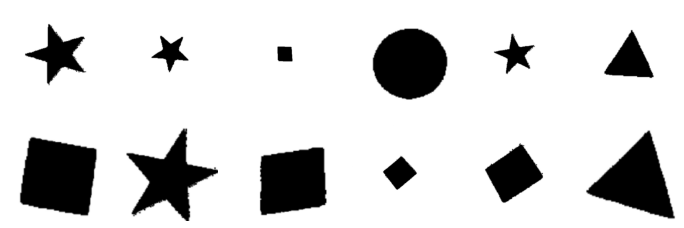

In [ ]:
figure = plt.figure(figsize=(12, 4))
cols, rows = 6, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
    sample = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    img, label = shapes_dataset[sample_idx] # index dataset (gets you the img and label - index)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
plt.show()

In [ ]:
for inputs, labels in training_loader:
  print(inputs.shape)
  print('Training set size',int(len(inputs)))
  #print(inputs)
  print(labels.shape)
  break

torch.Size([16, 3, 299, 299])
Training set size 16
torch.Size([16])


# Train and save models

In [ ]:
def train_model(model, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)    
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()     
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)     
    epoch_loss = running_loss / training_size
    epoch_acc = running_corrects.double() / training_size
    print('train Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))
    
def test_model(model, criterion):
  since = time.time()
  best_acc = 0.0
  model.eval()   # Set model to evaluate mode
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in validation_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
  epoch_loss = running_loss / validation_size
  epoch_acc = running_corrects.double() / validation_size
  print('test Loss: {:.4f} Acc: {:.4f}'.format(
      epoch_loss, epoch_acc))

In [ ]:
#test_names=['resnet_50','resnet_152','inception_v3','efficientnet_b4']
test_names=['resnet_50_4']
#XAI_save_path = '/content/drive/MyDrive/ColabNotebooks/Phase3/Nature/study1/'
model_save_path = '/content/drive/MyDrive/ColabNotebooks/Phase3/Nature/'
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True # https://github.com/pytorch/pytorch/issues/61755
model_ft=None
for test_name in test_names:
  model_weights_no_pretrained = model_save_path + 'shapes_'+test_name+'_weights_model_not_pretrained.pth'
  complete_model_no_pretrained = model_save_path + 'shapes_'+test_name+'_complete_model_not_pretrained.pth'
  if test_name == 'resnet_50_4':
    model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    model_ft.fc =  nn.Linear(in_features=model_ft.fc.in_features, out_features=num_classes, bias=True)
  elif test_name == 'resnet_152':
    model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False)
    model_ft.fc =  nn.Linear(in_features=model_ft.fc.in_features, out_features=num_classes, bias=True)
  elif test_name == 'inception_v3':
    model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
    model_ft.aux_logits=False  
    model_ft.fc =  nn.Linear(in_features=model_ft.fc.in_features, out_features=num_classes, bias=True)
  elif test_name == 'efficientnet_b4':
    # _b4
    model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=False)
    model_ft.fc =  nn.Linear(in_features=2048, out_features=num_classes, bias=True)
  else:
    print('--')
  model_ft.eval()
  print("Training:",test_name)
  model_ft = model_ft.to(device)
  num_epochs = 4
  criterion = nn.CrossEntropyLoss()
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print()
      train_model(model_ft, criterion, optimizer_ft)
      test_model(model_ft, criterion)
      scheduler.step()
  torch.save(model_ft.state_dict(), model_weights_no_pretrained)
  torch.save(model_ft, complete_model_no_pretrained)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training: resnet_50_4
Epoch 0/3

train Loss: 0.7079 Acc: 0.6730
test Loss: 0.2057 Acc: 0.9658
Epoch 1/3

train Loss: 0.1703 Acc: 0.9472
test Loss: 0.0452 Acc: 0.9926
Epoch 2/3

train Loss: 0.0853 Acc: 0.9762
test Loss: 0.0260 Acc: 0.9967
Epoch 3/3

train Loss: 0.0686 Acc: 0.9792
test Loss: 0.0059 Acc: 0.9993
